In [208]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [209]:
#read test and train datasets
mercedes_train = pd.read_csv('dataset/train.csv')
mercedes_test = pd.read_csv('dataset/test.csv')

In [210]:
print(mercedes_train.shape)
print(mercedes_test.shape)

(4209, 378)
(4209, 377)


In [211]:
mercedes_train.columns

Index(['ID', 'y', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8',
       ...
       'X375', 'X376', 'X377', 'X378', 'X379', 'X380', 'X382', 'X383', 'X384',
       'X385'],
      dtype='object', length=378)

In [212]:
print(mercedes_train.head())

   ID       y  X0 X1  X2 X3 X4 X5 X6 X8  ...  X375  X376  X377  X378  X379  \
0   0  130.81   k  v  at  a  d  u  j  o  ...     0     0     1     0     0   
1   6   88.53   k  t  av  e  d  y  l  o  ...     1     0     0     0     0   
2   7   76.26  az  w   n  c  d  x  j  x  ...     0     0     0     0     0   
3   9   80.62  az  t   n  f  d  x  l  e  ...     0     0     0     0     0   
4  13   78.02  az  v   n  f  d  h  d  n  ...     0     0     0     0     0   

   X380  X382  X383  X384  X385  
0     0     0     0     0     0  
1     0     0     0     0     0  
2     0     1     0     0     0  
3     0     0     0     0     0  
4     0     0     0     0     0  

[5 rows x 378 columns]


In [213]:
mercedes_train_dtype_info = mercedes_train.dtypes.reset_index()
mercedes_train_dtype_info.columns = ['feature', 'data type']
print(mercedes_train_dtype_info)

    feature data type
0        ID     int64
1         y   float64
2        X0    object
3        X1    object
4        X2    object
..      ...       ...
373    X380     int64
374    X382     int64
375    X383     int64
376    X384     int64
377    X385     int64

[378 rows x 2 columns]


In [214]:
mercedes_train_dtype_info.groupby('data type').aggregate('count').reset_index()

,data type,feature
0,int64,369
1,float64,1
2,object,8


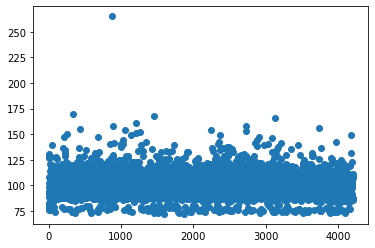

In [215]:
y = mercedes_train.y
plt.figure()
plt.scatter(range(mercedes_train.shape[0]), mercedes_train.y.values)
plt.show()

In [216]:
print(mercedes_train.y.max(), mercedes_train.y.idxmax())

265.32 883


In [217]:
mercedes_train.drop(index=883, inplace=True)

169.91 342


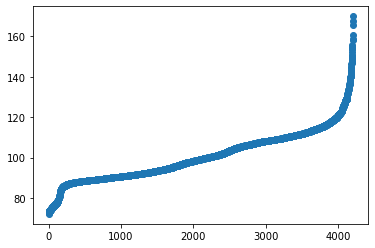

In [218]:
print(mercedes_train.y.max(), mercedes_train.y.idxmax())
plt.figure()
plt.scatter(range(mercedes_train.shape[0]), np.sort(mercedes_train.y.values))
plt.show()

In [219]:
no_of_bins = int(math.sqrt(mercedes_train.shape[0]))

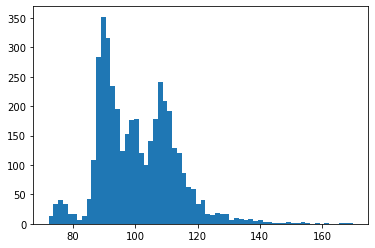

In [220]:
plt.figure()
plt.hist(mercedes_train.y.values, bins=no_of_bins)
plt.show()

Data Pre Processing

In [221]:
#Check for missing values in both test and train datasets
missing_columns_test = mercedes_test[[col for col in mercedes_test.columns if mercedes_test[col].isnull().any()==True]].isna().sum()
print(missing_columns_test.values)

missing_columns_train = mercedes_train[[col for col in mercedes_train.columns if mercedes_train[col].isnull().any()==True]].isna().sum()
print(missing_columns_train.values)

[]
[]


We find that there are no missing values in either dataset.

In [222]:
#encding the categorical variables
from sklearn import preprocessing
for obj in mercedes_train.select_dtypes('object'):
    mercedes_train[obj] = preprocessing.LabelEncoder().fit_transform(mercedes_train[obj])
    
#repeat for test dataset
for obj in mercedes_test.select_dtypes('object'):
    mercedes_test[obj] = preprocessing.LabelEncoder().fit_transform(mercedes_test[obj])

In [223]:
#remove features with zero variance as they are unlikely to influence final solution positively
from sklearn.feature_selection import VarianceThreshold

thresh = VarianceThreshold(threshold = 0.001)

removed_var_train = thresh.fit_transform(mercedes_train)
removed_var_test = thresh.fit_transform(mercedes_test)

filtered_train = mercedes_train[mercedes_train.columns[thresh.get_support(indices = True)]]
filtered_test = mercedes_test[mercedes_test.columns[thresh.get_support(indices = True)]]

In [224]:
print(filtered_train.shape)
print(filtered_test.shape)

(4208, 327)
(4209, 327)


So from 377 and 378 columns in test and train datasets respectively, we have 327 columns each remaining. Therefore, columns with zero variances have been dropped.

In [227]:
#remove highly correlated features
correlation_matrix_train = filtered_train.corr()
correlation_matrix_test = filtered_test.corr()
threshold = 0.95
np.fill_diagonal(correlation_matrix_train.values, -2)
np.fill_diagonal(correlation_matrix_test.values, -2)


In [228]:
filtered_train.drop(columns = correlation_matrix_train.columns[(correlation_matrix_train >= threshold).any()], inplace = True)
filtered_test.drop(columns = correlation_matrix_test.columns[(correlation_matrix_test >= threshold).any()], inplace = True)
#(correlation_matrix >= 0.85).any()

/home/brainwave/miniconda3/envs/directml/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [127]:
print(filtered_train.head())
filtered_train.shape
filtered_test.shape

        ID  X0  X1  X2  X3  X4  X5  X6  X8  X11  ...  X359  X361  X366  X369  \
0        0  32  23  17   0   3  24   9  14    0  ...     0     1     0     0   
1        6  32  21  19   4   3  28  11  14    0  ...     0     1     0     0   
2        7  20  24  34   2   3  27   9  23    0  ...     0     1     0     0   
3        9  20  21  34   5   3  27  11   4    0  ...     0     1     0     0   
4       13  20  23  34   5   3  12   3  13    0  ...     0     1     0     0   
...    ...  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...   ...   ...   ...   ...   
4204  8405   8  20  16   2   3   0   3  16    0  ...     0     1     0     0   
4205  8406  31  16  40   3   3   0   7   7    0  ...     0     1     0     0   
4206  8412   8  23  38   0   3   0   6   4    0  ...     0     1     0     0   
4207  8415   9  19  25   5   3   0  11  20    0  ...     0     1     0     0   
4208  8417  46  19   3   2   3   0   6  22    0  ...     0     1     0     0   

      X372  X375  X376  X377  X380  X38

(4208, 199)